In [1]:
# Useful starting lines
%matplotlib inline
%load_ext autoreload
%autoreload 2
#
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Import all functions from the Labs and helpers
import utils
import cleaner
import features_analysis

#sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn import linear_model, preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import normalize
from sklearn.neighbors import KNeighborsClassifier

# Data loading

In [44]:
DATASET_PATH = '../twitter-datasets/'
SAMPLE = False

In [45]:
if SAMPLE:
    train_pos_data = utils.load_training_data(DATASET_PATH + "train_pos.txt")
    train_neg_data = utils.load_training_data(DATASET_PATH + "train_neg.txt")
else:
    train_pos_data = utils.load_training_data(DATASET_PATH +
                                              "train_pos_full.txt")
    train_neg_data = utils.load_training_data(DATASET_PATH +
                                              "train_neg_full.txt")

train_target = np.concatenate(
    (np.ones(len(train_pos_data)), (-np.ones(len(train_neg_data))))
)
train_data = np.concatenate((train_pos_data, train_neg_data))
test_data = utils.load_test_data("../twitter-datasets/test_data.txt")

Successfully loaded data from ../twitter-datasets/train_pos_full.txt
Successfully loaded data from ../twitter-datasets/train_neg_full.txt
Successfully loaded data from ../twitter-datasets/test_data.txt


# Data preprocessing

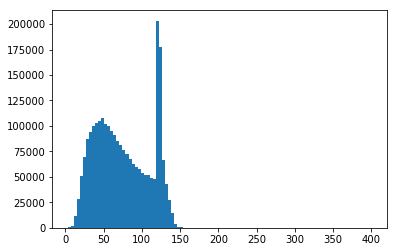

In [46]:
plt.hist([len(twit) for twit in train_data], bins=100)
plt.show()

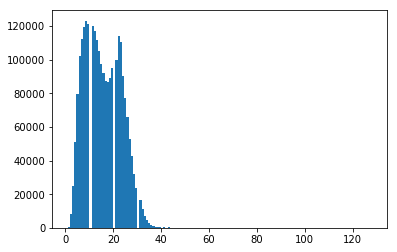

In [47]:
plt.hist([len(twit.split()) for twit in train_data], bins=140)
plt.show()

In [48]:
def remove_stop_word(stopwords, data):
    data_cleaned = []
    for tweet in data:
        tweet_words = tweet.split()
        tweet_words_cleaned = [word for word in tweet_words if word.lower() not in stopwords]
        data_cleaned.append(' '.join(tweet_words_cleaned))
        
    return data_cleaned

def decontraction(word):
    decontracted_word = ''
    decontracted_word = decontracted_word.replace("won't", "will not")
    decontracted_word = decontracted_word.replace("'t", " not")
    decontracted_word = decontracted_word.replace("'m", " am")
    decontracted_word = decontracted_word.replace("'ve", " have")
    decontracted_word = decontracted_word.replace("'ll", " will")
    decontracted_word = decontracted_word.replace("'d", " would")
    decontracted_word = decontracted_word.replace("n'd", " not")
    return decontracted_word

#def replace_number(word):
    
stop_words = ['<user>','<url>']
train_data_cleaned = remove_stop_word(stop_words,train_data)
test_data_clened = remove_stop_word(stop_words, test_data)

# Text representation

In [49]:
tfidf_vect = TfidfVectorizer(ngram_range=(1, 2), stop_words='english', max_df=0.8)

In [50]:
train_data_tdidf = tfidf_vect.fit_transform(train_data_cleaned)
test_data_tdidf = tfidf_vect.transform(train_data_cleaned)
feat_names = tfidf_vect.get_feature_names()

In [51]:
len(feat_names)

6166259

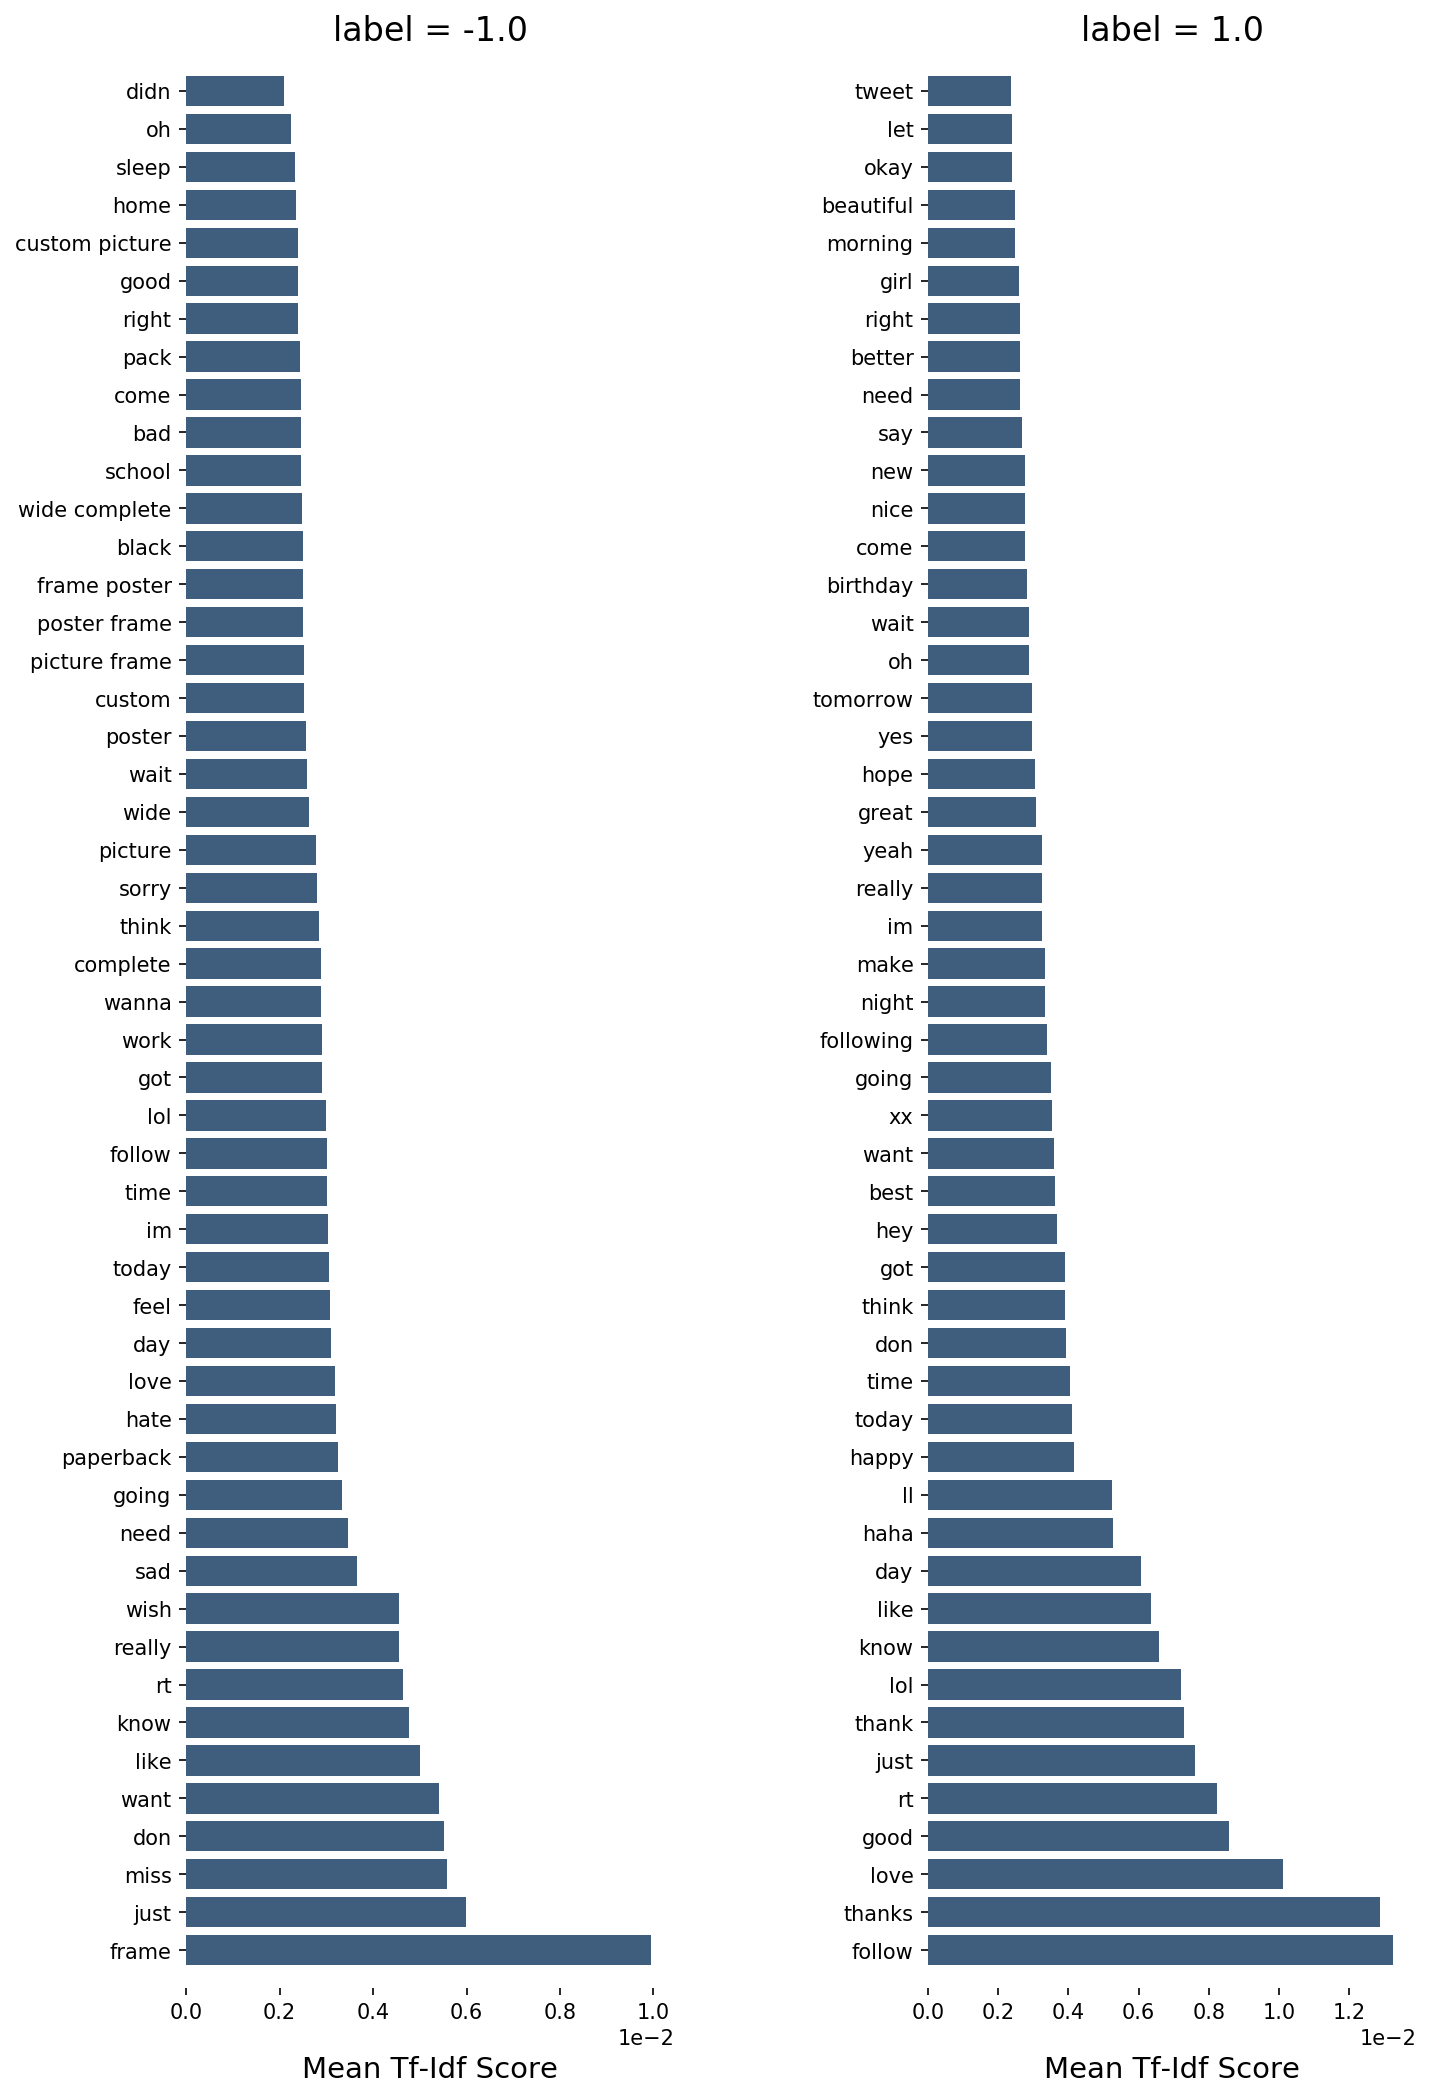

In [52]:
dfs = features_analysis.top_feats_by_class(train_data_tdidf, train_target, feat_names, top_n=50)
features_analysis.plot_tfidf_classfeats_h(dfs)

In [8]:
print(test_data_tdidf.shape)
print(train_data_tdidf.shape)

(10000, 825294)
(200000, 825294)


# Machine learning

## Model selection

In [5]:
classifiers = [
    MultinomialNB(),
    #KNeighborsClassifier(),
    SGDClassifier(alpha=1e-5, random_state=42),
    #SVC(gamma=2, C=1),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)
]

classifiers_names = [
    'naive Bayes',
    #'KNN',
    'Linear classifiers (SVM, logistic regression) with SGD',
    #'C-Support Vector Classification',
    'Random Forest'
]

def test_classifiers(classifiers, names, data, target, cv=3):
    for i, classifier in enumerate(classifiers):
        scores = cross_val_score(classifier, data, target, cv=cv, n_jobs=-1, verbose=10)
        print(names[i])
        print("Accuracy: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))

In [6]:
test_classifiers(classifiers, classifiers_names, train_data_tdidf, train_target)

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.7s finished


naive Bayes
Accuracy: 0.772 (+/- 0.001)


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.4s finished


Linear classifiers (SVM, logistic regression) with SGD
Accuracy: 0.792 (+/- 0.004)
Random Forest
Accuracy: 0.500 (+/- 0.000)


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.2s finished


## Model tuning

In [18]:
from sklearn.model_selection import GridSearchCV
parameters = {
    #'vect__max_df': (0.5, 0.75, 1.0),
    #'vect__ngram_range': ((1,1),(1, 2)),
    #'loss' : ('hinge', 'log','squared_loss', 'huber', 'epsilon_insensitive'),
    'alpha': (1e-4, 1e-5, 1e-6),
    #'penalty': ('l2', 'elasticnet'),
    'n_iter': (80,100,200),
}

gs_clf = GridSearchCV(SGDClassifier(alpha=1e-5, random_state=42), parameters, n_jobs=-1, verbose=10, cv=5)

In [19]:
gs_clf = gs_clf.fit(train_data_tdidf, train_target)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  43 out of  45 | elapsed:  2.4min remaining:    6.7s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  2.6min finished


In [20]:
gs_clf.best_score_

0.79624499999999998

In [21]:
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))

alpha: 1e-05
n_iter: 200


## Validation

# Generate submission

In [53]:
clf = SGDClassifier(alpha=5e-5, n_iter=80)
clf.fit(train_data_tdidf, train_target)
pred = clf.predict(test_data_tdidf)

In [54]:
utils.create_submission("submission", pred.astype(np.int64))

File submission.csv succesfully created with 10000 entries
